In [1]:
"""
author: William Darko (repurposed from original author Francois Chollet)
date: July, 2021
description: Regression problem using keras provided Boston housing dataset; example taken, an repurposed from 'Deep Learning with Python' (Manning publication, 1st ed) book by Francois Chollet
"""

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
from keras.datasets import boston_housing


In [2]:
# loading, and inspecting the data

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

print("Training data shape: ", train_data.shape)
print("Training targets shape: ", train_targets.shape)
print(train_data[:10])

# train_data.shape[0] corresponds to number of samples, in this case 404
# train_data.shape[1] corresponds to number of features per sample, in this case 13
# each sample represents a particular suburb in the Boston area, with 13 features such as crime rate, etc.
# targets represent median values of homes in thousands of dollars per sample

Training data shape:  (404, 13)
Training targets shape:  (404,)
[[1.23247e+00 0.00000e+00 8.14000e+00 0.00000e+00 5.38000e-01 6.14200e+00
  9.17000e+01 3.97690e+00 4.00000e+00 3.07000e+02 2.10000e+01 3.96900e+02
  1.87200e+01]
 [2.17700e-02 8.25000e+01 2.03000e+00 0.00000e+00 4.15000e-01 7.61000e+00
  1.57000e+01 6.27000e+00 2.00000e+00 3.48000e+02 1.47000e+01 3.95380e+02
  3.11000e+00]
 [4.89822e+00 0.00000e+00 1.81000e+01 0.00000e+00 6.31000e-01 4.97000e+00
  1.00000e+02 1.33250e+00 2.40000e+01 6.66000e+02 2.02000e+01 3.75520e+02
  3.26000e+00]
 [3.96100e-02 0.00000e+00 5.19000e+00 0.00000e+00 5.15000e-01 6.03700e+00
  3.45000e+01 5.98530e+00 5.00000e+00 2.24000e+02 2.02000e+01 3.96900e+02
  8.01000e+00]
 [3.69311e+00 0.00000e+00 1.81000e+01 0.00000e+00 7.13000e-01 6.37600e+00
  8.84000e+01 2.56710e+00 2.40000e+01 6.66000e+02 2.02000e+01 3.91430e+02
  1.46500e+01]
 [2.83920e-01 0.00000e+00 7.38000e+00 0.00000e+00 4.93000e-01 5.70800e+00
  7.43000e+01 4.72110e+00 5.00000e+00 2.87000e+

In [3]:
# normalising the data (feature-wise normalisaiton of data)
# because features values take wildy different ranges, this would make learning more difficult, thus feature normalisation is required to
# centre values around 0, and have unit standard deviations. This requires taking the mean of each feature column and for each feature subtracting the mean, and dividing by the standard deviation. This method is also recognised as Standardisation, or Z-score

feature_mean = train_data.mean(axis=0)
# pass axis=0 for the mean to be computed along the columns of the matrix (per feature column)

train_data-=feature_mean
stdev = train_data.std(axis=0)
train_data/=stdev
# train data is now a matrix of z-scores

test_data-=feature_mean
test_data/=stdev
# notice we use same mean, and standard deviation computed on training data; never use quantities computed on testing data. not even for normalisation

In [4]:
# model definition, and compilation
# because we'll be using k-fold validation, since the training data isn't enough to just split into a partial training set, and a validation set, we'll be partitionaling data according to k-folds cross validation, thus the model would have to be instantiated for each training partition.

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    # shape[1] corresponding to the number of features
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    # no activation used in the final layer to not restrict the range of outputs. A linear layer
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    # mse (mean squared error) for loss function, and mae (mean absolute error) for metrics
    # mse is the square of the difference between predictions and targets
    # mae is absolute value of difference between predictions and targets
    return model
# typical scalar regression model

In [5]:
# k-folds partitioning and cross validation

k = 4 # 4-fold validation
num_validation_samples = len(train_data) // k
# print("Length of train_data: {}, num validation samples {}".format(len(train_data), num_validation_samples))

num_epochs = 100
# all_scores = []
all_mae_histories = []

for i in range(k):
    print('processing fold #: ', i)
    validation_data = train_data[i * num_validation_samples: (i+1)*num_validation_samples]
    validation_targets = train_targets[i * num_validation_samples: (i+1)*num_validation_samples]
    print("i: {} , val data & targets: [{}:{}]".format(i, i*num_validation_samples, (i+1)*num_validation_samples))

    partial_train_data = np.concatenate( [train_data[:i*num_validation_samples], train_data[(i+1)*num_validation_samples:]], axis=0 )

    partial_train_targets = np.concatenate( [train_targets[:i*num_validation_samples], train_targets[(i+1)*num_validation_samples:]], axis=0 )

    model = build_model()
    # model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    # validation_mean_squared_error, validation_mean_absolute_error = model.evaluate(validation_data, validation_targets, verbose=0)

    # all_scores.append(validation_mean_absolute_error)
    num_epochs = 500
    history = model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0, validation_data=(validation_data, validation_targets))
    # print(history.history.keys())
    mean_abs_error_history = history.history['mae']
    all_mae_histories.append(mean_abs_error_history)

processing fold #:  0
i: 0 , val data & targets: [0:101]
processing fold #:  1
i: 1 , val data & targets: [101:202]
processing fold #:  2
i: 2 , val data & targets: [202:303]
processing fold #:  3
i: 3 , val data & targets: [303:404]


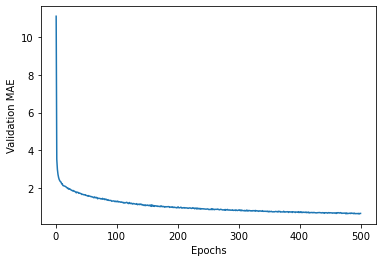

In [6]:
# building history of successive mean k-fold validation scores & plotting them
avg_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

plt.plot(range(1, len(avg_mae_history) + 1), avg_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


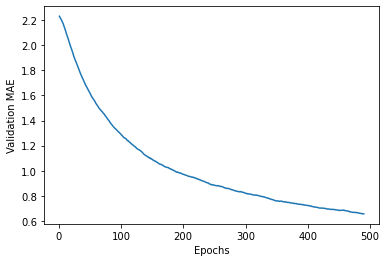

i: 0, mae: 1.4606817311117888
i: 1, mae: 1.45561840052037
i: 2, mae: 1.45114526374306
i: 3, mae: 1.4432800223514353
i: 4, mae: 1.4353646048979385
i: 5, mae: 1.4306496777304791
i: 6, mae: 1.422647404506992
i: 7, mae: 1.4152507583813583
i: 8, mae: 1.4079748809799595
i: 9, mae: 1.4021474379716854
i: 10, mae: 1.3964147113339789
i: 11, mae: 1.3871257700839659
i: 12, mae: 1.3797841279195864
i: 13, mae: 1.373649481697719
i: 14, mae: 1.3683148566757208
i: 15, mae: 1.3623369524366766
i: 16, mae: 1.3548983296293418
i: 17, mae: 1.350091736960864
i: 18, mae: 1.3432193083600308
i: 19, mae: 1.338794298443446
i: 20, mae: 1.333161485916301
i: 21, mae: 1.3307578260236301
i: 22, mae: 1.3243842656493174
i: 23, mae: 1.3190875919234741
i: 24, mae: 1.3148560260151614
i: 25, mae: 1.3096333772910942
i: 26, mae: 1.303582209137676
i: 27, mae: 1.3000156710633022
i: 28, mae: 1.295239633031641
i: 29, mae: 1.2900630137693476
i: 30, mae: 1.28305889082297


In [7]:
# Smoothing curve; omitting first 10 data points which are on a different scale than rest of curve

def smooth_curve(points, factor=0.9):
    i = 0
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1-factor))
            # if i % 10 == 0:
                # print("point: {}, previous: {}, appended: {}".format(point, previous, previous*factor+point*(1-factor)))
        else:
            smoothed_points.append(point)
    return smoothed_points

smoothed_mae_history = smooth_curve(avg_mae_history[10:])

plt.plot(range(1, len(smoothed_mae_history)+1), smoothed_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()
for i, mae in enumerate(smoothed_mae_history[70:101]):
    print("i: {}, mae: {}".format(i, mae))

4/4 [==============================] - 0s 1ms/step - loss: 16.6870 - mae: 2.6824


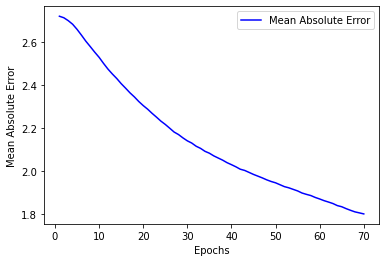

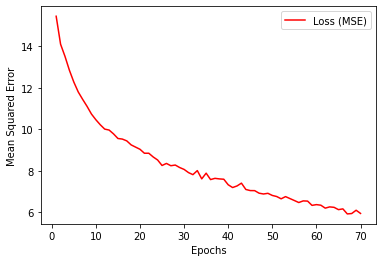

In [16]:
# tuning, and running tuned model on test data
test_num_epochs = 80
test_model = build_model()
test_history = test_model.fit(train_data, train_targets, epochs = test_num_epochs, batch_size=16, verbose=0)
test_mse, test_mae = test_model.evaluate(test_data, test_targets)

# print(test_history.history.keys())

test_history_mse = test_history.history['loss']
test_history_mae = test_history.history['mae']
smoothed_test_mae = smooth_curve(test_history_mae[10:])

plt.clf()
plt.plot(range(1,len(smoothed_test_mae)+1), smoothed_test_mae, 'b', label="Mean Absolute Error")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.show()

plt.clf()
plt.plot(range(1,len(test_history_mse[10:])+1), test_history_mse[10:], 'r', label="Loss (MSE)")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()